## MVP Engenharia de Dados

### Criação do esquema Medalhão

In [0]:
%sql
DROP SCHEMA IF EXISTS mvp_eng_dados.staging CASCADE;
DROP SCHEMA IF EXISTS mvp_eng_dados.bronze CASCADE;
DROP SCHEMA IF EXISTS mvp_eng_dados.silver CASCADE;
DROP SCHEMA IF EXISTS mvp_eng_dados.gold CASCADE;

In [0]:
%sql
USE CATALOG mvp_eng_dados


In [0]:
%sql
CREATE SCHEMA IF NOT EXISTS staging;
CREATE SCHEMA IF NOT EXISTS bronze;
CREATE SCHEMA IF NOT EXISTS silver;
CREATE SCHEMA IF NOT EXISTS gold

In [0]:
%sql
CREATE VOLUME IF NOT EXISTS mvp_eng_dados.staging.track_spotify_data;

In [0]:
%pip install kagglehub

import kagglehub
import shutil
import os

# Baixa o dataset
path = kagglehub.dataset_download(
    "wardabilal/spotify-global-music-dataset-20092025"
)

# Caminho do Unity Catalog Volume
uc_volume_path = "/Volumes/mvp_eng_dados/staging/track_spotify_data/"
os.makedirs(uc_volume_path, exist_ok=True)

# Nome do arquivo que queremos
target_file = "track_data_final.csv"

# Percorre os arquivos baixados
for file_name in os.listdir(path):
    if file_name == target_file:
        src_file = os.path.join(path, file_name)
        dst_file = os.path.join(uc_volume_path, file_name)
        shutil.copy2(src_file, dst_file)
        print(f"Arquivo {file_name} copiado com sucesso para {uc_volume_path}")
        break
else:
    raise FileNotFoundError(f"O arquivo {target_file} não foi encontrado no dataset.")


Note: you may need to restart the kernel using %restart_python or dbutils.library.restartPython() to use updated packages.
Arquivo track_data_final.csv copiado com sucesso para /Volumes/mvp_eng_dados/staging/track_spotify_data/


### Camada Bronze

In [0]:
%sql
DROP TABLE IF EXISTS bronze.track_spotify_data;

In [0]:
df = spark.read.csv(
    "/Volumes/mvp_eng_dados/staging/track_spotify_data",
    header=True,
    inferSchema=True
)

df.write.format("delta").mode("overwrite").saveAsTable(
    "mvp_eng_dados.bronze.track_spotify_data"
)

In [0]:
%sql
SELECT * FROM mvp_eng_dados.bronze.track_spotify_data
LIMIT (5)

track_id,track_name,track_number,track_popularity,track_duration_ms,explicit,artist_name,artist_popularity,artist_followers,artist_genres,album_id,album_name,album_release_date,album_total_tracks,album_type
6pymOcrCnMuCWdgGVTvUgP,3,57,61,213173,False,Britney Spears,80.0,1.7755451E7,['pop'],325wcm5wMnlfjmKZ8PXIIn,The Singles Collection,2009-11-09,58,compilation
2lWc1iJlz2NVcStV5fbtPG,Clouds,1,67,158760,False,BUNT.,69.0,293734.0,['stutter house'],2ArRQNLxf9t0O0gvmG5Vsj,Clouds,2023-01-13,1,single
1msEuwSBneBKpVCZQcFTsU,Forever & Always (Taylor’s Version),11,63,225328,False,Taylor Swift,100.0,1.45396321E8,[],4hDok0OAJd57SGIT8xuWJH,Fearless (Taylor's Version),2021-04-09,26,album
7bcy34fBT2ap1L4bfPsl9q,I Didn't Change My Number,2,72,158463,True,Billie Eilish,90.0,1.18692183E8,[],0JGOiO34nwfUdDrD612dOp,Happier Than Ever,2021-07-30,16,album
0GLfodYacy3BJE7AI3A8en,Man Down,7,57,267013,False,Rihanna,90.0,6.8997177E7,[],5QG3tjE5L9F6O2vCAPph38,Loud,2010-01-01,13,album


### Camada Silver

In [0]:
from pyspark.sql.functions import col, when, coalesce, lit, expr

# Leitura da tabela bronze
df = spark.read.table("mvp_eng_dados.bronze.track_spotify_data")

# Tratamento de colunas numéricas
df_clean = (
    df.withColumn(
        "artist_popularity",
        coalesce(
            expr("try_cast(artist_popularity as double)"),
            lit(0.0)
        )
    )
    .withColumn(
        "artist_followers",
        coalesce(
            expr("try_cast(artist_followers as bigint)"),
            lit(0)
        )
    )
)

# Colunas categóricas para preenchimento
categorical_columns = [
    "track_id",
    "track_name",
    "track_popularity",
    "track_duration_ms",
    "explicit",
    "artist_name",
    "artist_genres",
    "album_id",
    "album_name",
    "album_release_date",
    "album_total_tracks",
    "album_type"
]

# Preencher nulos com "Unknown"
df_clean = df_clean.fillna("Unknown", subset=categorical_columns)

# Tratamento da coluna album_type
valid_album_types = ["album", "single", "compilation"]

df_clean = df_clean.withColumn(
    "album_type",
    when(col("album_type").isin(valid_album_types), col("album_type"))
    .otherwise(lit("Unknown"))
)

# Tratamento da coluna explicit
valid_explicit_values = ["True", "False"]

df_clean = df_clean.withColumn(
    "explicit",
    when(col("explicit").isin(valid_explicit_values), col("explicit"))
    .otherwise(lit("Unknown"))
)

# Escrita na tabela Silver (Delta)
(
    df_clean
    .write
    .format("delta")
    .mode("overwrite")
    .option("overwriteSchema", "true")
    .saveAsTable("mvp_eng_dados.silver.track_spotify_data_clean")
)


In [0]:
%sql
SELECT * FROM mvp_eng_dados.silver.track_spotify_data_clean
LIMIT (5)

track_id,track_name,track_number,track_popularity,track_duration_ms,explicit,artist_name,artist_popularity,artist_followers,artist_genres,album_id,album_name,album_release_date,album_total_tracks,album_type
6pymOcrCnMuCWdgGVTvUgP,3,57,61,213173,False,Britney Spears,80.0,17755451,['pop'],325wcm5wMnlfjmKZ8PXIIn,The Singles Collection,2009-11-09,58,compilation
2lWc1iJlz2NVcStV5fbtPG,Clouds,1,67,158760,False,BUNT.,69.0,293734,['stutter house'],2ArRQNLxf9t0O0gvmG5Vsj,Clouds,2023-01-13,1,single
1msEuwSBneBKpVCZQcFTsU,Forever & Always (Taylor’s Version),11,63,225328,False,Taylor Swift,100.0,145396321,[],4hDok0OAJd57SGIT8xuWJH,Fearless (Taylor's Version),2021-04-09,26,album
7bcy34fBT2ap1L4bfPsl9q,I Didn't Change My Number,2,72,158463,True,Billie Eilish,90.0,118692183,[],0JGOiO34nwfUdDrD612dOp,Happier Than Ever,2021-07-30,16,album
0GLfodYacy3BJE7AI3A8en,Man Down,7,57,267013,False,Rihanna,90.0,68997177,[],5QG3tjE5L9F6O2vCAPph38,Loud,2010-01-01,13,album


### Camada Gold

In [0]:
# Leitura da tabela Silver
df = spark.read.table("mvp_eng_dados.silver.track_spotify_data_clean")

# Colunas a serem removidas para análise
columns_to_drop = [
    "track_number",
    "artist_genres",
    "album_id",
    "album_total_tracks",
    "album_name",
    "album_release_date"
]

df_final = df.drop(*columns_to_drop)

# Escrita na tabela Gold (Delta)
(
    df_final
    .write
    .format("delta")
    .mode("overwrite")
    .option("overwriteSchema", "true")
    .saveAsTable("mvp_eng_dados.gold.track_spotify_data_final")
)

In [0]:
%sql
SELECT * FROM mvp_eng_dados.gold.track_spotify_data_final
LIMIT (5)

track_id,track_name,track_popularity,track_duration_ms,explicit,artist_name,artist_popularity,artist_followers,album_type
6pymOcrCnMuCWdgGVTvUgP,3,61,213173,False,Britney Spears,80.0,17755451,compilation
2lWc1iJlz2NVcStV5fbtPG,Clouds,67,158760,False,BUNT.,69.0,293734,single
1msEuwSBneBKpVCZQcFTsU,Forever & Always (Taylor’s Version),63,225328,False,Taylor Swift,100.0,145396321,album
7bcy34fBT2ap1L4bfPsl9q,I Didn't Change My Number,72,158463,True,Billie Eilish,90.0,118692183,album
0GLfodYacy3BJE7AI3A8en,Man Down,57,267013,False,Rihanna,90.0,68997177,album


### Perguntas a serem respondidas

1. A popularidade do artista influencia a popularidade da faixa?
2. Artistas com mais seguidores lançam faixas mais populares?
3. Singles são, em média, mais populares do que faixas de álbuns?
4. O conteúdo explícito afeta a popularidade da faixa?
5. Existe uma faixa de duração mais comum entre músicas populares?
6. Faixas muito populares (“hits”) possuem características diferentes do restante do catálogo?

In [0]:
from pyspark.sql import functions as F
from pyspark.sql.window import Window

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy.stats import pearsonr, spearmanr, ttest_ind, mannwhitneyu, kruskal

In [0]:
df = spark.read.table("mvp_eng_dados.gold.track_spotify_data_final")


In [0]:
df.select("track_popularity").describe().show()


+-------+------------------+
|summary|  track_popularity|
+-------+------------------+
|  count|              8778|
|   mean| 52.22920938710413|
| stddev|24.077234236240773|
|    min|                 0|
|    max|               100|
+-------+------------------+



In [0]:
%sql
SELECT
  MIN(track_popularity) AS min_pop,
  MAX(track_popularity) AS max_pop,
  AVG(track_popularity) AS avg_pop,
  PERCENTILE_CONT(0.5) WITHIN GROUP (ORDER BY track_popularity) AS median_pop
FROM mvp_eng_dados.gold.track_spotify_data_final;


min_pop,max_pop,avg_pop,median_pop
0,100,52.22920938710413,58.0


Interpretação

Média 52,23 com mínimo em 0 e máximo em 100. Mediana 58 → Distribuição equilibrada com leve assimetria para a esquerda (média<mediana).

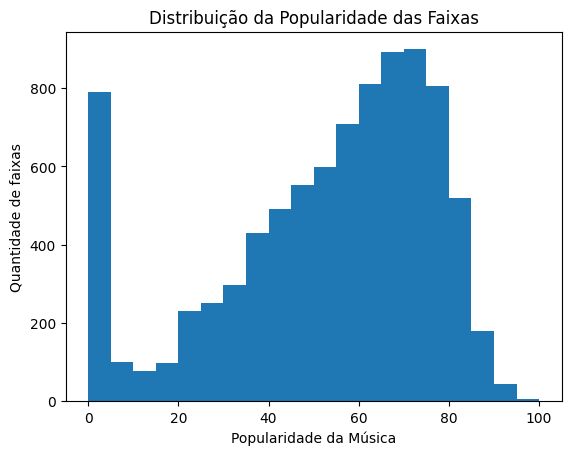

In [0]:
pdf = df.select("track_popularity").dropna().toPandas()

plt.figure()
plt.hist(pdf["track_popularity"], bins=20)
plt.xlabel("Popularidade da Música")
plt.ylabel("Quantidade de faixas")
plt.title("Distribuição da Popularidade das Faixas")
plt.show()


In [0]:
%sql
SELECT
  track_popularity,
  COUNT(*) AS qtd
FROM mvp_eng_dados.gold.track_spotify_data_final
GROUP BY track_popularity
ORDER BY track_popularity DESC;

track_popularity,qtd
100,1
99,1
97,1
95,2
94,3
93,7
92,10
91,13
90,11
89,14


In [0]:
import pyspark.pandas as ps

df_box = ps.read_table("mvp_eng_dados.gold.track_spotify_data_final")
df_box["track_popularity"].plot.box()

/databricks/python/lib/python3.12/site-packages/pyspark/pandas/utils.py:1054: PandasAPIOnSparkAdviceWarning:

If `index_col` is not specified for `read_table`, the default index is attached which can cause additional overhead.



Interpretação:

50% das faixas estão entre 39 e 71 → 1/4 das músicas são populares.

IQR (Q3 − Q1) = 71 − 39 = 32 pontos

Isso é um intervalo relativamente amplo para uma escala de 0 a 100.

→ Há heterogeneidade real de performance entre as faixas.

**Pergunta 1**  
A popularidade do artista influencia a popularidade da faixa?

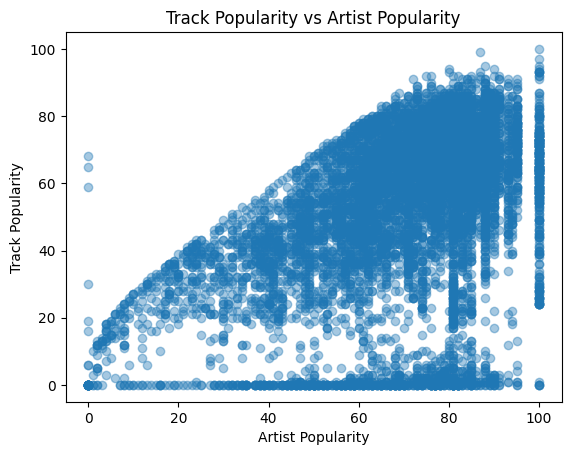

In [0]:
pdf_artist = (
    df.select("track_popularity", "artist_popularity")
      .dropna()
      .toPandas()
)

plt.figure()
plt.scatter(
    pdf_artist["artist_popularity"],
    pdf_artist["track_popularity"],
    alpha=0.4
)
plt.xlabel("Artist Popularity")
plt.ylabel("Track Popularity")
plt.title("Track Popularity vs Artist Popularity")
plt.show()


Os casos de músicas com a popularidade maior do que 80 são evidentemente maiores em artistas mais populares. (artist_popularity>60)

**Pergunta 2**  
Artistas com mais seguidores lançam faixas mais populares?

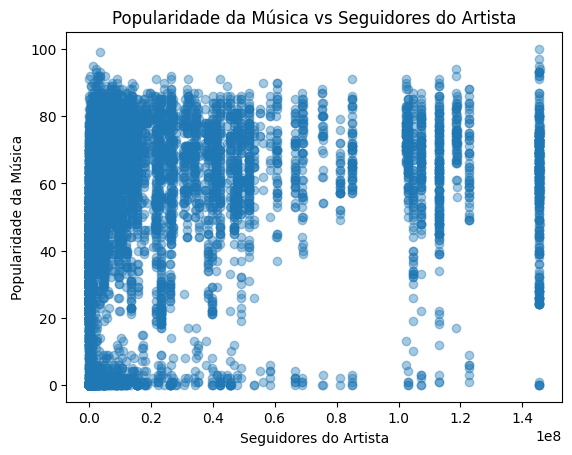

In [0]:
pdf_followers = (
    df.select("track_popularity", "artist_followers")
      .dropna()
      .toPandas()
)

plt.figure()
plt.scatter(
    pdf_followers["artist_followers"],
    pdf_followers["track_popularity"],
    alpha=0.4
)
plt.xlabel("Seguidores do Artista")
plt.ylabel("Popularidade da Música")
plt.title("Popularidade da Música vs Seguidores do Artista")
plt.show()


Número de seguidores - base de fãs - não é um fator que sozinho influencia a popularidade da música.

**Pergunta 3**  
Singles são, em média, mais populares do que faixas de álbuns?

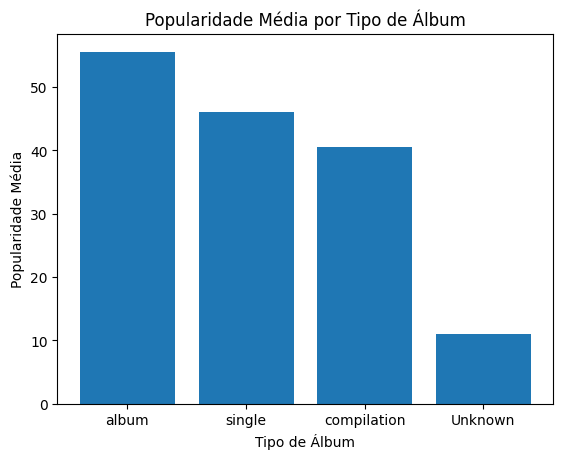

In [0]:
pdf_album = (
    df.groupBy("album_type")
      .agg(F.avg("track_popularity").alias("avg_popularity"))
      .orderBy("avg_popularity", ascending=False)
      .toPandas()
)

plt.figure()
plt.bar(pdf_album["album_type"], pdf_album["avg_popularity"])
plt.xlabel("Tipo de Álbum")
plt.ylabel("Popularidade Média")
plt.title("Popularidade Média por Tipo de Álbum")
plt.show()


Álbuns tendem a elevar a popularidade da música, mesmo na era dos streamings.

**Pergunta 4**  
O conteúdo explícito afeta a popularidade da faixa?

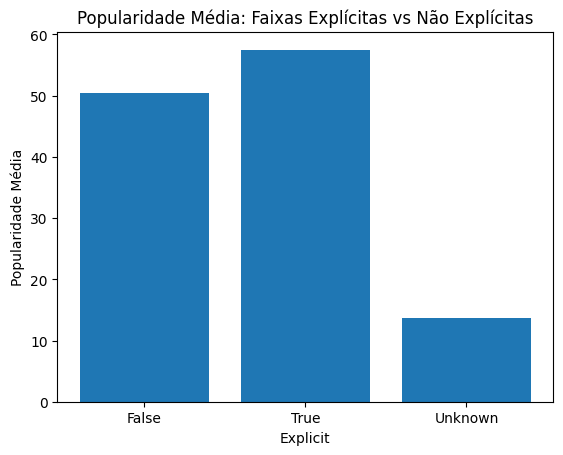

In [0]:
pdf_explicit = (
    df.groupBy("explicit")
      .agg(F.avg("track_popularity").alias("avg_popularity"))
      .toPandas()
)

plt.figure()
plt.bar(pdf_explicit["explicit"].astype(str), pdf_explicit["avg_popularity"])
plt.xlabel("Explicit")
plt.ylabel("Popularidade Média")
plt.title("Popularidade Média: Faixas Explícitas vs Não Explícitas")
plt.show()


Faixas explícitas tendem a ser mais populares.

**Pergunta 5**  
Existe uma faixa de duração mais comum entre músicas populares?

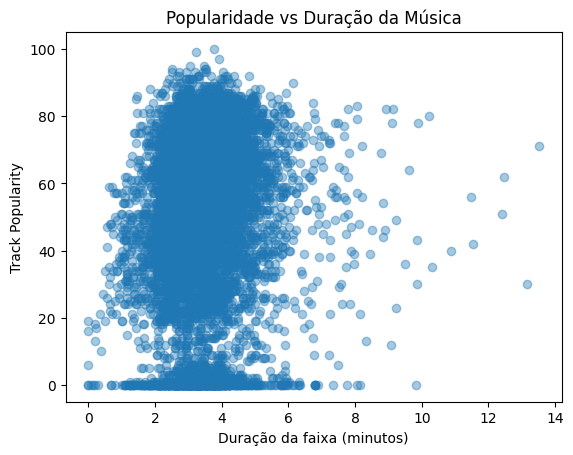

In [0]:
pdf_duration = (
    df.select("track_duration_ms", "track_popularity")
      .dropna()
      .toPandas()
)

plt.figure()
plt.scatter(
    pdf_duration["track_duration_ms"] / 60000,
    pdf_duration["track_popularity"],
    alpha=0.4
)
plt.xlabel("Duração da faixa (minutos)")
plt.ylabel("Track Popularity")
plt.title("Popularidade vs Duração da Música")
plt.show()


Há uma clara preferência de músicas entre 2 e 4 minutos.

**Segmentação de Popularidade da Música**

In [0]:
df_segmented = df.withColumn(
    "popularity_segment",
    F.when(F.col("track_popularity") <= 20, "Baixa")
     .when(F.col("track_popularity") <= 50, "Média")
     .when(F.col("track_popularity") <= 80, "Alta")
     .otherwise("Muito Alta")
)

df_segmented.groupBy("popularity_segment").count().withColumn(
        "order_col",
        F.when(F.col("popularity_segment") == "Baixa", 4)
         .when(F.col("popularity_segment") == "Média", 3)
         .when(F.col("popularity_segment") == "Alta", 2)
         .when(F.col("popularity_segment") == "Muito Alta", 1)
    ).orderBy("order_col").drop("order_col").show()

+------------------+-----+
|popularity_segment|count|
+------------------+-----+
|        Muito Alta|  619|
|              Alta| 4732|
|             Média| 2326|
|             Baixa| 1101|
+------------------+-----+



Surpreendente concentração de músicas com popularidade alta. (>50 e <=80)

### Conclusões

Os resultados indicam que a popularidade de uma faixa é fortemente influenciada pela popularidade prévia do artista. Músicas com altos níveis de popularidade concentram-se, em sua maioria, em artistas já consolidados, o que reforça a importância de alcance, visibilidade e reputação no desempenho das faixas nas plataformas de streaming.

Em contrapartida, o número de seguidores não se mostrou um fator determinante de forma isolada. Embora represente o tamanho da base de fãs, ele não garante, por si só, maior popularidade das músicas, sugerindo que outros elementos — como estratégias de lançamento, curadoria e características do conteúdo — exercem papel relevante.

A análise também revela que faixas pertencentes a álbuns tendem a ser mais populares do que singles, mesmo no contexto atual do streaming. Além disso, músicas com conteúdo explícito apresentam maior popularidade média, e há uma preferência clara por faixas com duração entre 2 e 4 minutos, alinhada aos padrões de consumo da audiência.

Por fim, observa-se uma forte concentração de músicas muito populares em torno de características específicas, indicando que os “hits” seguem padrões relativamente bem definidos. Esse conjunto de evidências reforça que o sucesso musical é multifatorial e resultado da combinação entre atributos do artista, formato de lançamento e características da faixa.